In [198]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time
import cPickle as pickle

import qgrid

%load_ext autoreload
%autoreload 2

from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

#qgrid.nbinstall(overwrite=True)
#qgrid.show_grid(df[['open_lifts', 'new_24']], remote_js=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [178]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/data_with_features/all_feat.csv', parse_dates=True, index_col=0)

#### Drop 'to' and 'from' traffic columns

In [179]:
df.drop(['away_WP', 'to_WP'], axis=1, inplace=True)

#### Drop the NaNs and inf scale data

In [180]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(0, inplace=True)

#### Get a list of the features

In [181]:
features = list(df.columns[1:].values)

#### Scale the data

In [182]:
df_sc, standard_scale_fit = scale_features(df[features])
df_final = pd.concat([df.skiers, df_sc], axis=1)
df_final.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,pres_day_sun_sqrt,ln_pres_day_sun,pres_day_fri_sq,pres_day_fri_cu,pres_day_fri_sqrt,ln_pres_day_fri,pres_day_mon_sq,pres_day_mon_cu,pres_day_mon_sqrt,ln_pres_day_mon
2011-11-13,44,-0.273109,-1.600583,-2.264483,-2.786694,-2.055275,-1.459053,-0.269834,-0.175318,-0.202770,...,-0.079008,0,-0.079008,-0.079008,-0.079008,0,-0.079008,-0.079008,-0.079008,0
2011-11-14,-1467,-0.273109,-1.600583,-2.264483,-2.786694,-2.055275,-1.425871,-0.269834,-0.351279,-0.202770,...,-0.079008,0,-0.079008,-0.079008,-0.079008,0,-0.079008,-0.079008,-0.079008,0
2011-11-15,-1580,-0.273109,-1.600583,-2.264483,-2.786694,-2.055275,-1.425871,-0.269834,-0.351279,-0.408778,...,-0.079008,0,-0.079008,-0.079008,-0.079008,0,-0.079008,-0.079008,-0.079008,0
2011-11-16,-1315,-0.273109,-1.600583,-2.264483,-2.786694,-2.055275,-1.414810,-0.269834,-0.351279,-0.408778,...,-0.079008,0,-0.079008,-0.079008,-0.079008,0,-0.079008,-0.079008,-0.079008,0
2011-11-17,-1202,-0.273109,-1.600583,-2.264483,-2.786694,-2.055275,-1.403749,-0.269834,-0.351279,-0.408778,...,-0.079008,0,-0.079008,-0.079008,-0.079008,0,-0.079008,-0.079008,-0.079008,0


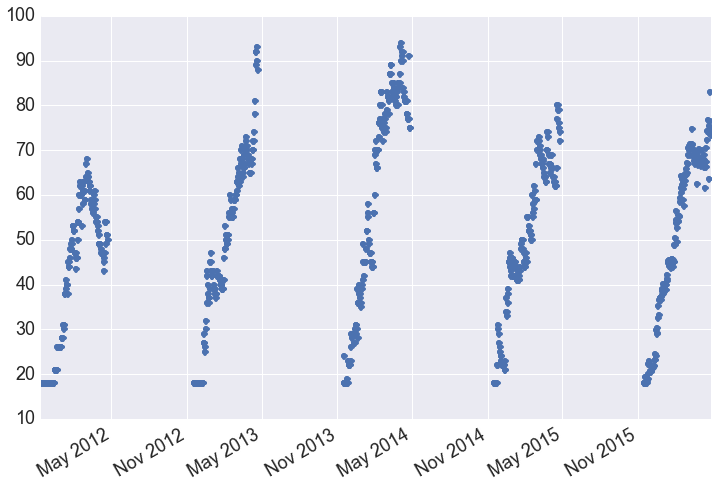

In [183]:
df.basedepth.plot(linestyle='', marker='o')

### Create a training and holdout set

In [184]:
df_tr = df.ix[datetime.datetime(2011,11,1):datetime.datetime(2014,5,1)]
df_h = df.ix[datetime.datetime(2014,11,1):datetime.datetime(2015,5,1)]
df_fut = df.ix[datetime.datetime(2011,5,1):]

In [185]:
df_tr.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,pres_day_sun_sqrt,ln_pres_day_sun,pres_day_fri_sq,pres_day_fri_cu,pres_day_fri_sqrt,ln_pres_day_fri,pres_day_mon_sq,pres_day_mon_cu,pres_day_mon_sqrt,ln_pres_day_mon
2011-11-13,44,1,18,0,0,0,1,9.1,2.6,3.9,...,0,0,0,0,0,0,0,0,0,0
2011-11-14,-1467,1,18,0,0,0,4,9.1,2.0,3.9,...,0,0,0,0,0,0,0,0,0,0
2011-11-15,-1580,1,18,0,0,0,4,9.1,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2011-11-16,-1315,1,18,0,0,0,5,9.1,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2011-11-17,-1202,1,18,0,0,0,6,9.1,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0


## Forward selection

In [186]:
lin_regr = linear_model.LinearRegression()

In [187]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [188]:
X_tr = df_tr[features]
y_tr = df_tr.skiers.values
X_h = df_h[features].values

In [189]:
leave_out = ['day_5', 'midweek', 'day_0', 'before_xmas']
features_input = [f for f in features if f not in leave_out]

In [190]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 25, features_input)

Next best Feature:  open_lifts_cu , RMSE:  1831.7 #: 5
Next best Feature:  xmas , RMSE:  1573.2 #: 6
Next best Feature:  month_4 , RMSE:  1452.2 #: 7
Next best Feature:  tot_snow_sq , RMSE:  1418.1 #: 8
Next best Feature:  pres_day_sun , RMSE:  1390.3 #: 9
Next best Feature:  mlk_day , RMSE:  1376.0 #: 10
Next best Feature:  pres_day_sat , RMSE:  1362.7 #: 11
Next best Feature:  mlk_sun , RMSE:  1359.6 #: 12
Next best Feature:  mlk_sat , RMSE:  1356.9 #: 13
Next best Feature:  ln_6day_snow_tot , RMSE:  1355.4 #: 14
Next best Feature:  week_snow_tot , RMSE:  1352.3 #: 15
Next best Feature:  xmas_mon , RMSE:  1350.5 #: 16
Next best Feature:  before_xmas_sat , RMSE:  1349.4 #: 17
Next best Feature:  before_xmas_fri , RMSE:  1347.8 #: 18
Next best Feature:  pres_day_mon , RMSE:  1347.0 #: 19
Next best Feature:  pres_day_sun_sq , RMSE:  1347.0 #: 20
Next best Feature:  pres_day_mon_sq , RMSE:  1347.0 #: 21
Next best Feature:  pres_day_mon_cu , RMSE:  1347.0 #: 22
Next best Feature:  ln_pres

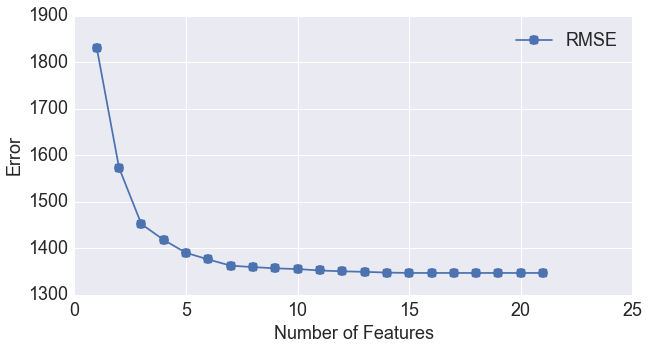

In [191]:
plot_error_vs_features(RMSE, 'none', 'none')

Features: ['day_5', 'midweek', 'day_0']
Features: ['day_5', 'midweek', 'day_0', 'before_xmas', 'open_lifts_cu']
Features: ['day_5', 'midweek', 'day_0', 'before_xmas', 'open_lifts_cu', 'xmas', 'month_4']
Features: ['day_5', 'midweek', 'day_0', 'before_xmas', 'open_lifts_cu', 'xmas', 'month_4', 'tot_snow_sq', 'pres_day_sun']
Features: ['day_5', 'midweek', 'day_0', 'before_xmas', 'open_lifts_cu', 'xmas', 'month_4', 'tot_snow_sq', 'pres_day_sun', 'mlk_day', 'pres_day_sat']
Features: ['day_5', 'midweek', 'day_0', 'before_xmas', 'open_lifts_cu', 'xmas', 'month_4', 'tot_snow_sq', 'pres_day_sun', 'mlk_day', 'pres_day_sat', 'mlk_sun', 'mlk_sat']
Features: ['day_5', 'midweek', 'day_0', 'before_xmas', 'open_lifts_cu', 'xmas', 'month_4', 'tot_snow_sq', 'pres_day_sun', 'mlk_day', 'pres_day_sat', 'mlk_sun', 'mlk_sat', 'ln_6day_snow_tot', 'week_snow_tot']


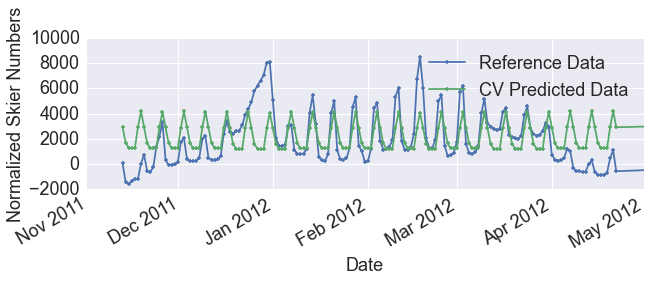

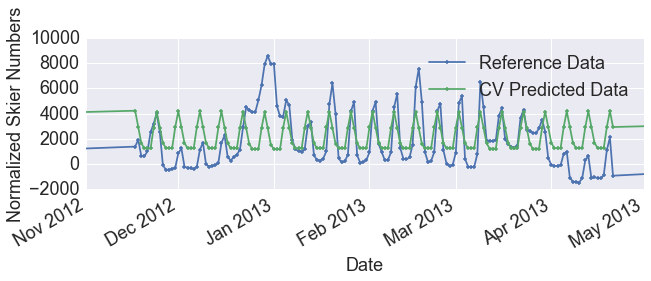

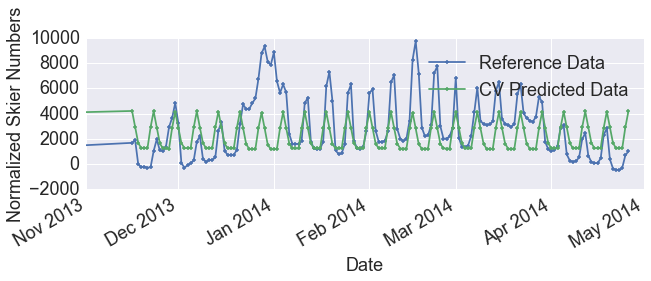

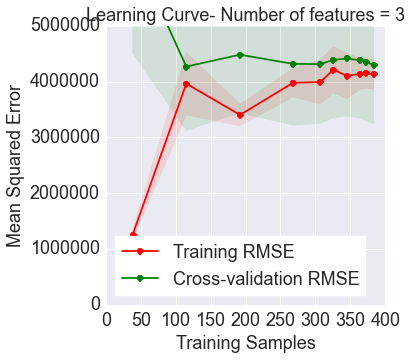

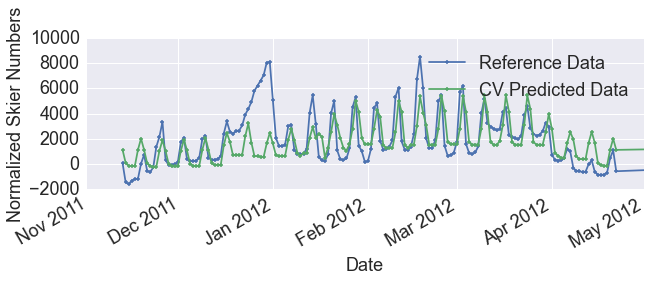

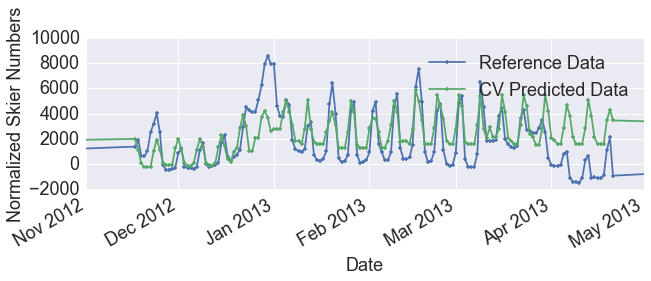

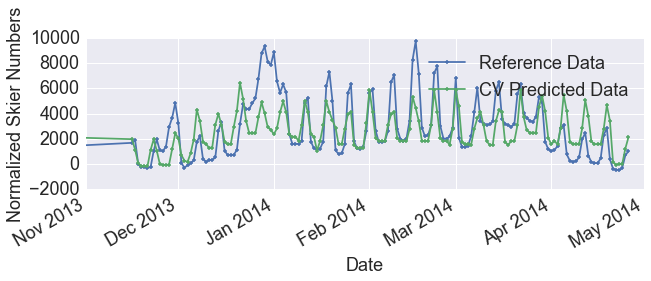

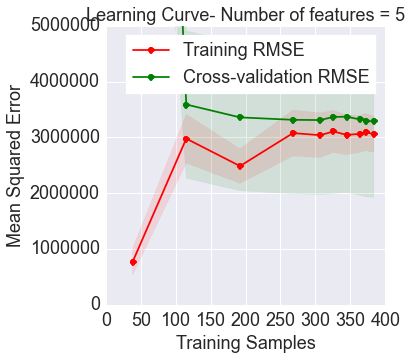

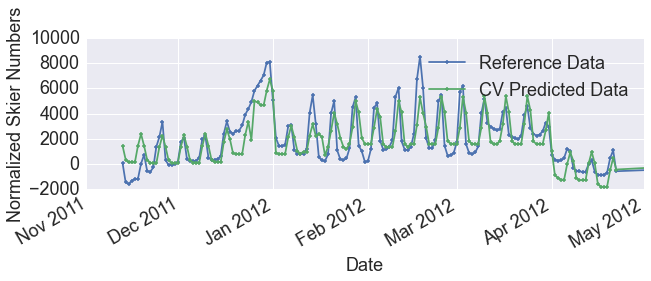

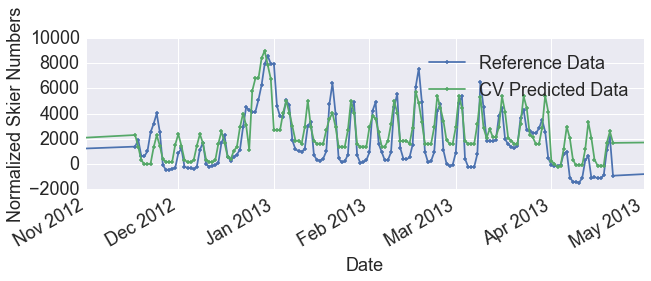

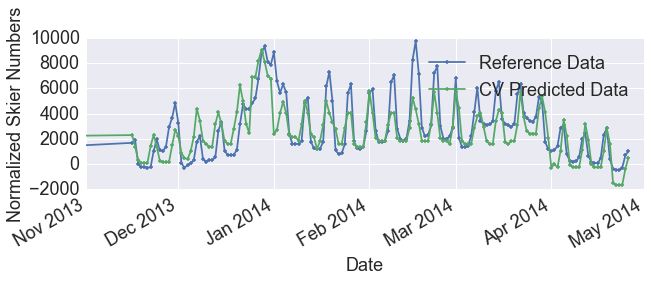

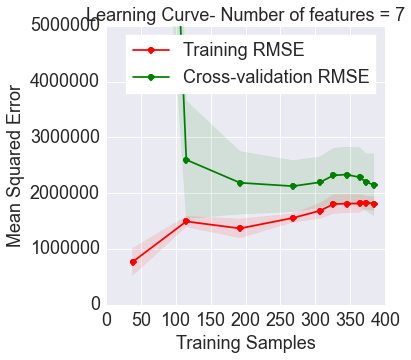

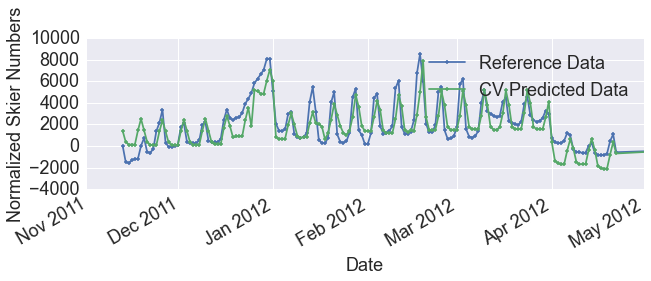

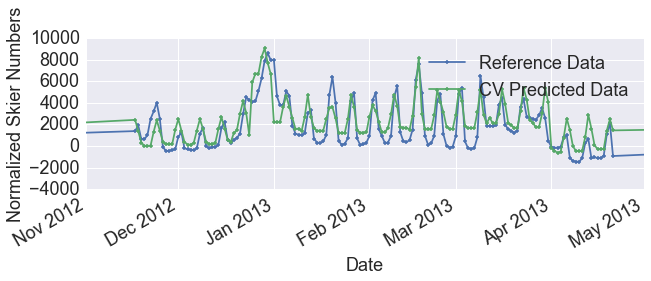

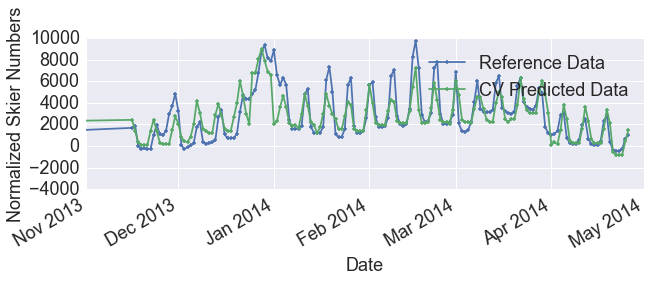

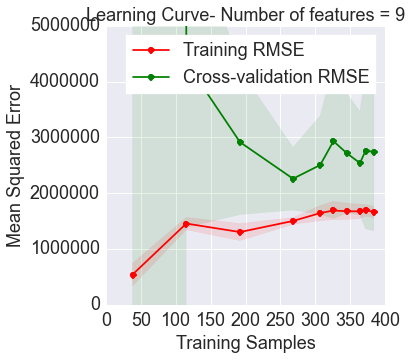

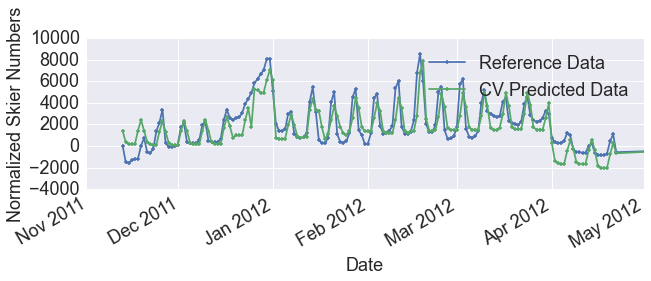

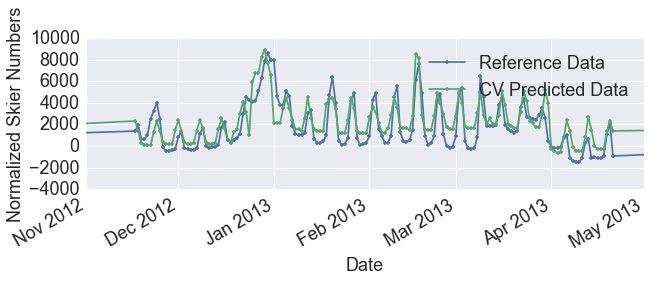

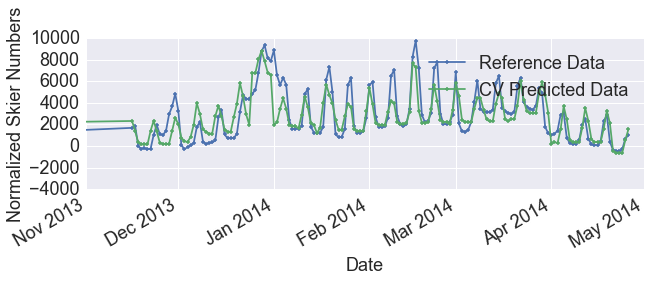

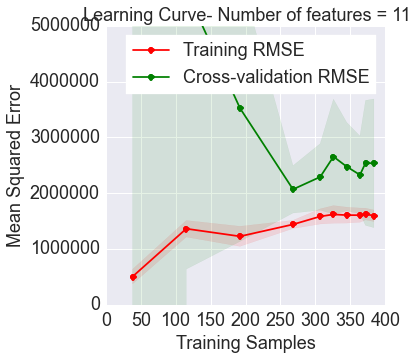

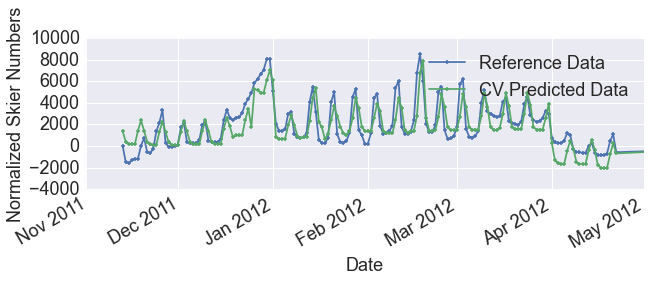

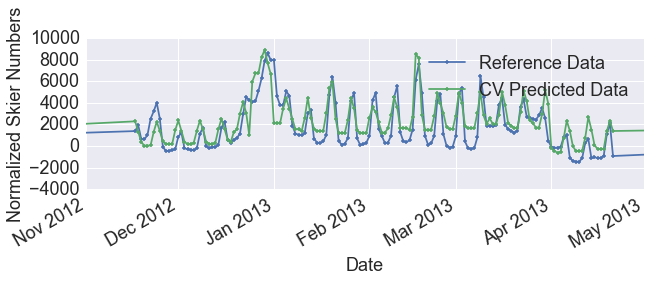

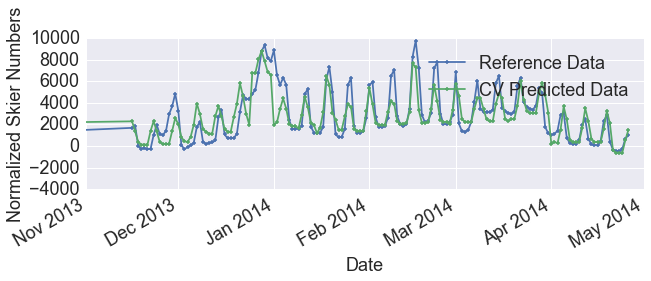

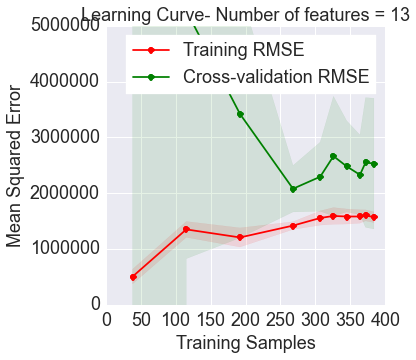

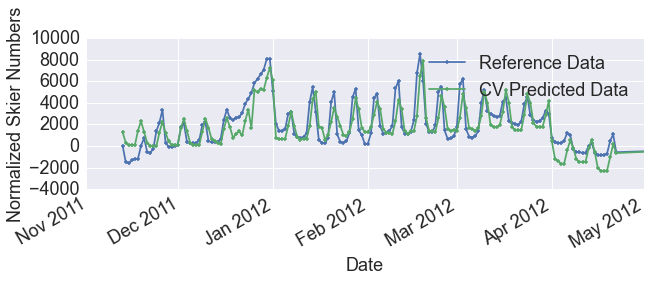

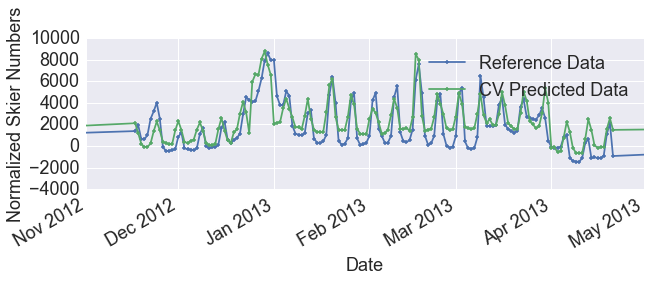

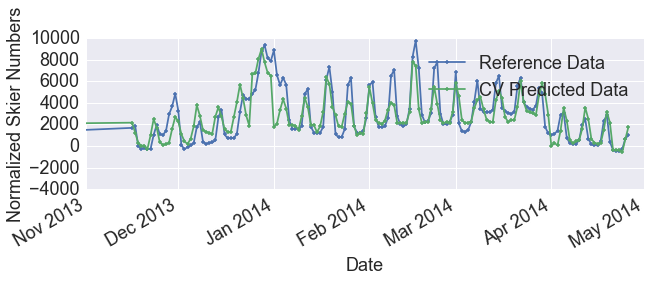

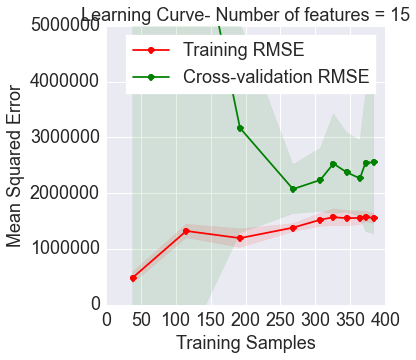

In [192]:
i = 3
while i < 16:
    num_good_feat = i
    df_reg = pd.concat([df_tr.skiers, df_tr[fs_features[0:i]]], axis=1)
    X_tr = df_tr[fs_features[0:i]]
    y_tr = df_tr.skiers.values
    mdl = lin_regr.fit(X_tr, y_tr) 
    cv_pred = cross_val_predict(lin_regr, X_tr, y_tr, cv = 100)
    df_reg['cv_pred'] = cv_pred
    print 'Features:', fs_features[0:i]
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'])
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])
    plot_fitted_and_ref_vs_time(df_reg, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'])
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,5000000), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

### Lasso

In [193]:
clf = linear_model.Lasso(alpha=0.1)
lasso = clf.fit(X_tr, y_tr)
cv_pred_lasso = cross_val_predict(lasso, X_tr, y_tr, cv = 10)

In [207]:
features = list(df_tr.columns.values)
features.remove('skiers')

In [211]:
best_lambda, lambda_lasso, coefs, mean_score_lambda = find_best_lambda(linear_model.Lasso, features, X_tr, y_tr, 0.0000001, 10000000, 2)

lambda: 1e-07
score: 1352.0
lambda: 2e-07
score: 1352.0
lambda: 4e-07
score: 1352.0
lambda: 8e-07
score: 1352.0
lambda: 1.6e-06
score: 1352.0
lambda: 3.2e-06
score: 1352.0
lambda: 6.4e-06
score: 1352.0
lambda: 1.28e-05
score: 1352.0
lambda: 2.56e-05
score: 1352.0
lambda: 5.12e-05
score: 1352.0
lambda: 0.0001024
score: 1352.0
lambda: 0.0002048
score: 1352.0
lambda: 0.0004096
score: 1352.0
lambda: 0.0008192
score: 1352.0
lambda: 0.0016384
score: 1352.0
lambda: 0.0032768
score: 1352.0
lambda: 0.0065536
score: 1352.0
lambda: 0.0131072
score: 1352.0
lambda: 0.0262144
score: 1352.0
lambda: 0.0524288
score: 1352.0
lambda: 0.1048576
score: 1352.0
lambda: 0.2097152
score: 1352.0
lambda: 0.4194304
score: 1353.0
lambda: 0.8388608
score: 1354.0
lambda: 1.6777216
score: 1356.0
lambda: 3.3554432
score: 1363.0
lambda: 6.7108864
score: 1381.0
lambda: 13.4217728
score: 1414.0
lambda: 26.8435456
score: 1455.0
lambda: 53.6870912
score: 1547.0
lambda: 107.3741824
score: 1794.0
lambda: 214.7483648
score: 2

In [ ]:
plot_lambda(lambda_lasso, coefs, mean_score_lambda)

In [194]:
df_tr['lasso_pred'] = cv_pred_lasso

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


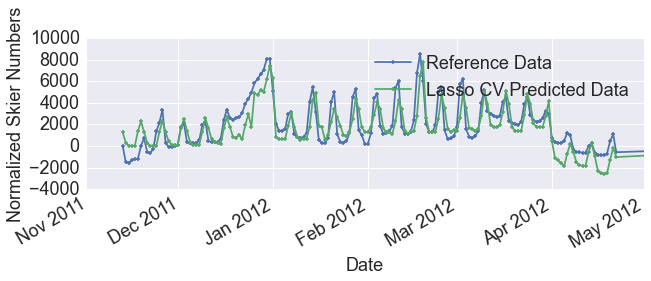

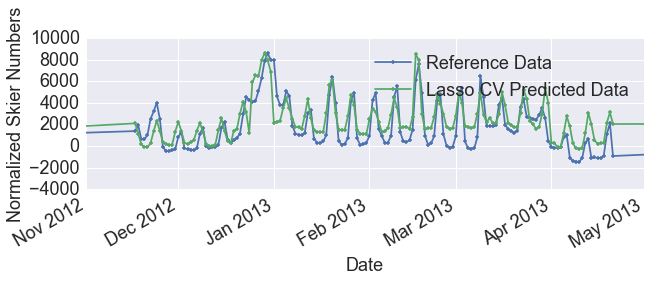

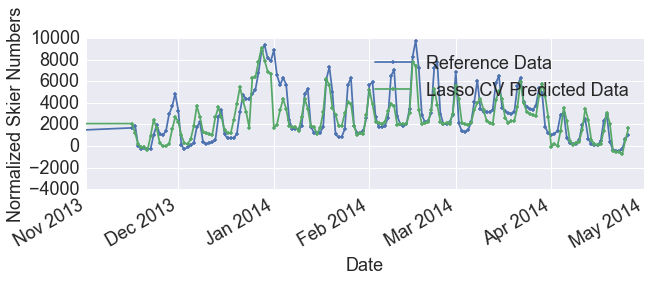

In [195]:
%matplotlib inline
plot_lasso_and_ref_vs_time(df_tr, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'])
plot_lasso_and_ref_vs_time(df_tr, ref_column, ['2012-11-1 00:00:00', '2013-05-1 00:00:00'])
plot_lasso_and_ref_vs_time(df_tr, ref_column, ['2013-11-1 00:00:00', '2014-05-1 00:00:00'])

AttributeError: 'DataFrame' object has no attribute 'model_pred'

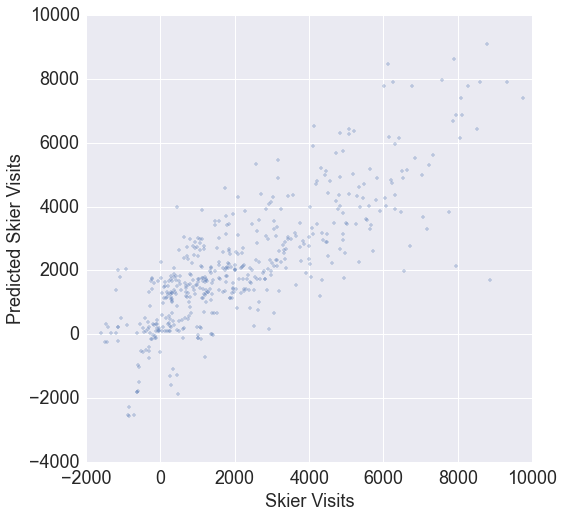

In [199]:
fitted_vs_ref_plot(df_tr, ref_column)

In [ ]:
df_all.head()

### Export Model

In [ ]:
#saving pickle file as .p is best
pickle_out = open('lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

# Export Data

In [ ]:
df_out = df_all.drop(['model_pred','skiers'], axis=1)

In [ ]:
df_out.to_csv('../webpage_ski/df_all_features.csv')